In [1]:
import numpy as np
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import adadelta
from keras.regularizers import l1
import pydot
import matplotlib.pyplot as plt 

Using TensorFlow backend.


In [2]:
def shallow_autoencoder(input_size,embed_size):
    
    x_in = Input(shape=(input_size,))
    X_EN=Dense(embed_size,activation='relu')(x_in)
    X_De=Dense(input_size,activation='sigmoid')(X_EN)
    shallow_autoencoder=Model(inputs=x_in,outputs=X_De)
    
    # encoder model
    
    encoder= Model(inputs=x_in,outputs=X_EN)
    # decoder model
    x_en= Input(shape=(embed_size,))
    decode_layer=shallow_autoencoder.layers[-1]
    decoder= Model(inputs=x_en,outputs=decode_layer(x_en))
    
    
    return shallow_autoencoder,encoder,decoder
    

In [3]:
shallow_autoencoder, encoder, decoder = shallow_autoencoder(input_size=784,embed_size=64)

In [5]:
shallow_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [6]:
def model_compile(model,opt,los):
    model.compile(optimizer=opt,loss=los)
    return model
    
    
def model_train(model,x_train,y_train,x_test,y_test,batch_size,epochs,shuffle=True): # generic for image denoising 
    history=model.fit(x_train, x_train,epochs=epochs,batch_size=batch_size,shuffle=True,validation_data=(x_test, x_test))
    return model,history

shallow_autoencoder=model_compile(shallow_autoencoder, opt='adadelta',los='binary_crossentropy')


In [48]:
def data_loading():
    from keras.datasets import mnist
    (x_train,_), (x_test,_) = mnist.load_data()
    return x_train,x_test

x_train , x_test = data_loading()



def image_noise(x_train,x_test):
    
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
    noise_factor = 0.5
    x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    return x_train_noisy,x_test_noisy


x_train_noisy,x_test_noisy=image_noise(x_train,x_test)

In [49]:
x_train_noisy.shape

(60000, 28, 28, 1)

In [50]:
import cv2


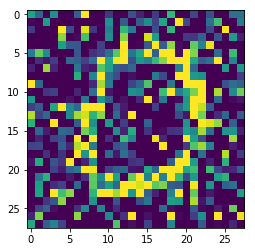

In [51]:
image=x_test_noisy[10]

image.shape

plt.imshow(image.reshape(28,28))

In [52]:
def data_preprocess(x):
    return (x.astype('float32')).reshape(x.shape[0],np.prod(x.shape[1:]))

x_train_noisy_flat=data_preprocess(x_train_noisy)
x_train_flat=data_preprocess(x_train)
x_test_noisy_flat=data_preprocess(x_test_noisy)
x_test_flat=data_preprocess(x_test)



In [53]:
x_test_noisy_flat.shape

(10000, 784)

In [55]:
shallow_autoencoder, history = model_train(shallow_autoencoder,x_train=x_train_noisy_flat,y_train=x_train_flat,x_test=x_test_noisy_flat,y_test=x_test_flat,batch_size=256,epochs=50,shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.5012 - val_loss: 0.5011
Epoch 2/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.5010 - val_loss: 0.5009
Epoch 3/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.5008 - val_loss: 0.5008
Epoch 4/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.5007 - val_loss: 0.5006
Epoch 5/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.5006 - val_loss: 0.5006
Epoch 6/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.5005 - val_loss: 0.5005
Epoch 7/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.5004 - val_loss: 0.5004
Epoch 8/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.5003 - val_loss: 0.5003
Epoch 9/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.5002 - val_loss: 0.5003
Epoch

In [37]:
def model_generation(model,image):
    recon_image = model.predict(image)
    return recon_image

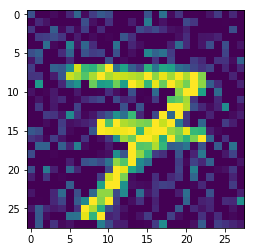

In [46]:
index=np.random.randint(0,100)    
image=x_test_noisy_flat[index]
image.shape
image=np.expand_dims(image,axis=0)
image.shape    

recon_image=model_generation(shallow_autoencoder,image)

or_image= image.reshape(image.shape[0],28,28,1)
recon_image=recon_image.reshape(recon_image.shape[0],28,28,1)

plt.figure
plt.imshow(or_image[0].reshape(28,28))

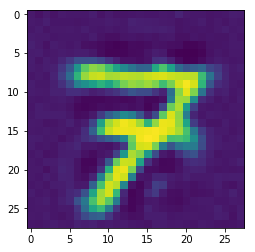

In [47]:
plt.figure
plt.imshow(recon_image[0].reshape(28,28))